# Viterbi Decoding Mechanics — Word: FOUR

**Task**: Demonstrate the mechanics of the Viterbi algorithm for the spoken word "FOUR" (/f/ /oʊ/ /r/ End) using a 4-state Left-to-Right HMM.
This notebook covers:
1.  HMM Structure & Topology
2.  Initialization ($\delta_1$)
3.  Induction (Viterbi Step vs Forward)
4.  Backtracking (using $\psi$)
5.  Full Algorithm Demonstration

**Date**: 2025-12-09


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
import os

# Set seed for reproducibility
np.random.seed(42)

# Create figs directory
if not os.path.exists('./figs'):
    os.makedirs('./figs')

def save_show(fname):
    """Save figure and show it."""
    plt.savefig(os.path.join('./figs', fname), bbox_inches='tight', dpi=100)
    plt.show()

print("Environment ready. Figures will be saved to ./figs/")


Environment ready. Figures will be saved to ./figs/


## 1. HMM Structure + Visualization

We model the word **FOUR** using a Left-to-Right HMM with 4 states.
The phoneme sequence is strict: /f/ $	o$ /oʊ/ $	o$ /r/ $	o$ End.

**States:**
*   $S_1$: /f/ (Start)
*   $S_2$: /oʊ/
*   $S_3$: /r/
*   $S_4$: End (Final/Absorbing)

**Parameters (Simple Numeric Examples):**
*   **Transitions ($A$)**: We assume a 50% chance to stay in the current phoneme and 50% chance to move to the next.
*   **Emissions ($B$)**: For this demonstration, we define emission probabilities $b_i(O_t)$ directly for a hypothetical observation sequence $O = [O_1, O_2, O_3, O_4]$. This simplifies the math to focus on the Viterbi mechanics.


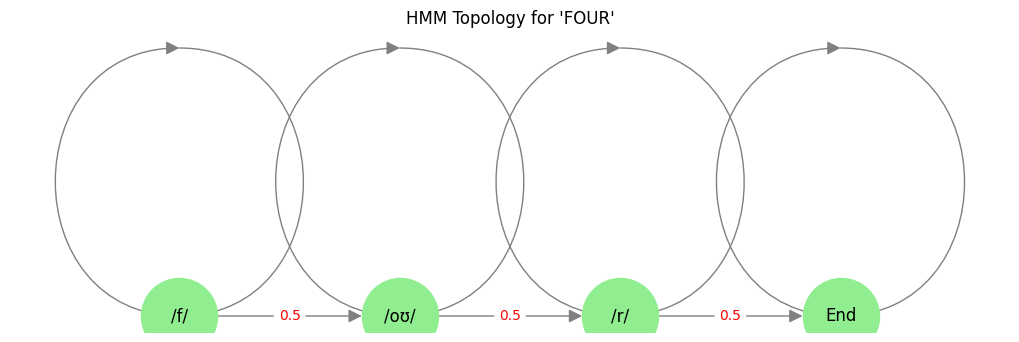

In [2]:
# Define States
states = ["/f/", "/oʊ/", "/r/", "End"]
n_states = len(states)

# Transition Matrix A (Rows sum to 1)
# S1->S1, S1->S2
# S2->S2, S2->S3
# S3->S3, S3->S4
# S4->S4 (Loop)
A = np.array([
    [0.5, 0.5, 0.0, 0.0],
    [0.0, 0.5, 0.5, 0.0],
    [0.0, 0.0, 0.5, 0.5],
    [0.0, 0.0, 0.0, 1.0]
])

# Initial Probabilities (Must start at S1)
pi = np.array([1.0, 0.0, 0.0, 0.0])

# Pre-defined Emission Probabilities for observations O1..O4
# Rows = States, Cols = Time steps (t=0 to t=3 corresponding to O1..O4)
# We design these to favor the path S1->S2->S3->S4
B_obs = np.array([
    [0.8, 0.1, 0.0, 0.0],  # S1 (/f/) likes O1
    [0.1, 0.7, 0.1, 0.0],  # S2 (/oʊ/) likes O2
    [0.0, 0.1, 0.8, 0.0],  # S3 (/r/) likes O3
    [0.0, 0.0, 0.1, 1.0]   # S4 (End) likes O4
])

def plot_topology(A, states):
    G = nx.DiGraph()
    for i, s in enumerate(states):
        G.add_node(s)
    
    edge_labels = {}
    rows, cols = A.shape
    for i in range(rows):
        for j in range(cols):
            if A[i, j] > 0:
                G.add_edge(states[i], states[j])
                edge_labels[(states[i], states[j])] = f"{A[i, j]:.1f}"
    
    pos = {
        "/f/": (0, 0),
        "/oʊ/": (1, 0),
        "/r/": (2, 0),
        "End": (3, 0)
    }
    
    plt.figure(figsize=(10, 3))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightgreen', 
            font_size=12, arrowsize=20, edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title("HMM Topology for 'FOUR'")
    save_show("four_topology.png")

plot_topology(A, states)


### Structure Explanation
This **Left-to-Right** topology enforces the temporal order of speech.
*   **Zero Backward Transitions**: You cannot go from /r/ back to /f/.
*   **Self-loops**: Allow for duration modeling (staying in a phoneme for multiple frames).
*   **Forward Transitions**: Move to the next phoneme in the sequence.


## 2. Part (a): Initialization Step

### Question
Explain the $\delta_1(i)$ formula and why $\delta_1(i)=0$ for all $i 
eq S_1$.

### Explanation
The Viterbi algorithm initializes by calculating the probability of starting in each state $i$ and observing the first observation $O_1$.

**Formula:**
$$ \delta_1(i) = \pi_i \cdot b_i(O_1) $$

Where:
*   $\pi_i$: Initial state probability ($P(q_1 = S_i)$).
*   $b_i(O_1)$: Probability of observing $O_1$ given state $S_i$.

**Linguistic Reasoning:**
For a single word model like "FOUR", the pronunciation **must** start with the first phoneme /f/. Therefore, the probability of starting at /oʊ/, /r/, or End is zero.
*   $\pi = [1, 0, 0, 0]$
*   Consequently, $\delta_1(i) = 0$ for all states except $S_1$ (/f/).


Initialization Values:
      delta_1 (t=1)
/f/             0.8
/oʊ/            0.0
/r/             0.0
End             0.0


/tmp/ipykernel_10371/3770543398.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_init.index, y=df_init["delta_1 (t=1)"], palette="Blues_d")


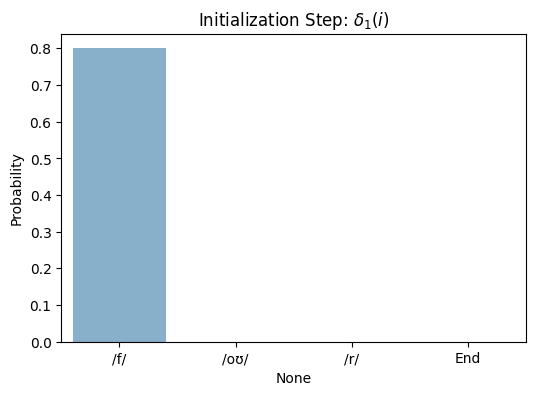

In [3]:
# Initialization Step (t=0 in 0-indexed python, t=1 in math)
# Observation O1 corresponds to column 0 of B_obs

delta = np.zeros((n_states, 4)) # Table to store delta values
psi = np.zeros((n_states, 4), dtype=int) # Table to store backpointers

# Compute delta_1
# delta[i, 0] = pi[i] * B_obs[i, 0]
delta[:, 0] = pi * B_obs[:, 0]

# Display
df_init = pd.DataFrame(delta[:, 0], index=states, columns=["delta_1 (t=1)"])
print("Initialization Values:")
print(df_init)

# Visual
plt.figure(figsize=(6, 4))
sns.barplot(x=df_init.index, y=df_init["delta_1 (t=1)"], palette="Blues_d")
plt.title("Initialization Step: $\delta_1(i)$")
plt.ylabel("Probability")
save_show("delta_init.png")


### Part (a) Answer
> **Answer**:
> The initialization formula is $\delta_1(i) = \pi_i \cdot b_i(O_1)$.
> For the word "FOUR", the initial state distribution is $\pi = [1, 0, 0, 0]$ because the word must strictly begin with the phoneme /f/.
> Therefore, for any state $i 
eq S_1$, $\pi_i = 0$, which forces $\delta_1(i) = 0 \cdot b_i(O_1) = 0$. Only the start state $S_1$ has a non-zero probability.


## 3. Part (b): Viterbi Induction Step

### Question
Explain why Viterbi computes:
$$ \delta_t(i) = \max_j [\delta_{t-1}(j) \cdot a_{ji}] \cdot b_i(O_t) $$
while the Forward algorithm uses summation.

### Explanation
*   **Viterbi Algorithm (Max)**: The goal is to find the **single best (most likely) state sequence** (path) that explains the data. We want the maximum probability path reaching state $i$ at time $t$. We take the `max` over previous states $j$ to select the best predecessor.
*   **Forward Algorithm (Sum)**: The goal is to calculate the **total probability** of the observation sequence given the model, summing over **all possible** underlying state paths.

**Conceptual Difference:**
*   **Viterbi**: "What is the best path to get here?" (Optimization)
*   **Forward**: "What is the total likelihood of getting here via any path?" (Integration/Summation)


--- Viterbi Induction Trace ---

Time step t=2 (Observation O2)
  State /f/: Max prev (/f/) val=0.4000 * emit=0.10 -> delta=0.04000
  State /oʊ/: Max prev (/f/) val=0.4000 * emit=0.70 -> delta=0.28000

Time step t=3 (Observation O3)
  State /oʊ/: Max prev (/oʊ/) val=0.1400 * emit=0.10 -> delta=0.01400
  State /r/: Max prev (/oʊ/) val=0.1400 * emit=0.80 -> delta=0.11200

Time step t=4 (Observation O4)
  State End: Max prev (/r/) val=0.0560 * emit=1.00 -> delta=0.05600

Delta Table (Probabilities):
      t=1   t=2    t=3    t=4
/f/   0.8  0.04  0.000  0.000
/oʊ/  0.0  0.28  0.014  0.000
/r/   0.0  0.00  0.112  0.000
End   0.0  0.00  0.000  0.056

Psi Table (Backpointers):
      t=1  t=2   t=3   t=4
/f/   /f/  /f/   /f/   /f/
/oʊ/  /f/  /f/  /oʊ/  /oʊ/
/r/   /f/  /f/  /oʊ/   /r/
End   /f/  /f/   /f/   /r/


/tmp/ipykernel_10371/2933747599.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_psi_mapped = df_psi.applymap(lambda x: states[x])


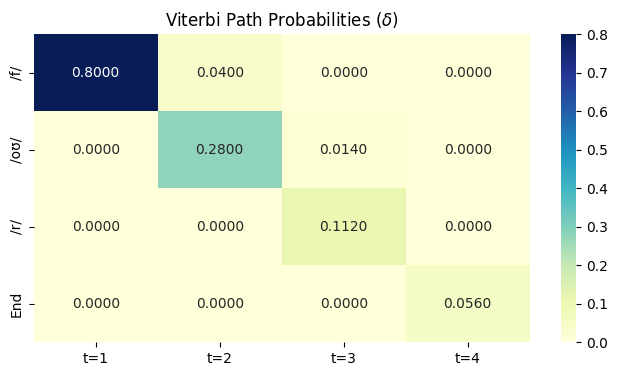

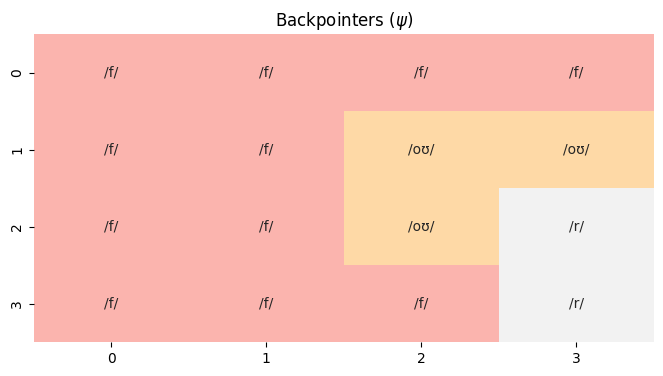

In [4]:
# Induction Step
# We manually compute for t=2, 3, 4 (indices 1, 2, 3)

print("--- Viterbi Induction Trace ---")

for t in range(1, 4): # Loop over time steps 2, 3, 4
    print(f"\nTime step t={t+1} (Observation O{t+1})")
    for i in range(n_states): # Loop over current states (destination)
        # Calculate candidates: delta_{t-1}(j) * a_{ji}
        candidates = delta[:, t-1] * A[:, i]
        
        # Find max and argmax
        best_prev_prob = np.max(candidates)
        best_prev_state = np.argmax(candidates)
        
        # Multiply by emission probability
        emission = B_obs[i, t]
        delta[i, t] = best_prev_prob * emission
        psi[i, t] = best_prev_state
        
        # Print non-zero computations for clarity
        if delta[i, t] > 0:
            print(f"  State {states[i]}: Max prev ({states[best_prev_state]}) val={best_prev_prob:.4f} * emit={emission:.2f} -> delta={delta[i, t]:.5f}")

# Display Delta Table
df_delta = pd.DataFrame(delta, index=states, columns=["t=1", "t=2", "t=3", "t=4"])
print("\nDelta Table (Probabilities):")
print(df_delta)

# Display Psi Table
df_psi = pd.DataFrame(psi, index=states, columns=["t=1", "t=2", "t=3", "t=4"])
# Map indices to state names for readability
df_psi_mapped = df_psi.applymap(lambda x: states[x])
print("\nPsi Table (Backpointers):")
print(df_psi_mapped)

# Visual: Heatmap of Delta
plt.figure(figsize=(8, 4))
sns.heatmap(df_delta, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Viterbi Path Probabilities ($\delta$)")
save_show("delta_induction_tables.png")

# Visual: Table of Pointers
plt.figure(figsize=(8, 4))
# We visualize pointers as a heatmap of indices just to show structure, but text is key
sns.heatmap(psi, annot=df_psi_mapped.values, fmt="", cmap="Pastel1", cbar=False)
plt.title("Backpointers ($\psi$)")
save_show("psi_pointer_table.png")


### Part (b) Answer
> **Answer**:
> The Viterbi algorithm uses the **maximization (max)** operation because it seeks the **single most likely state sequence** (optimal path).
> $$ \delta_t(i) = \max_j [\delta_{t-1}(j) \cdot a_{ji}] \cdot b_i(O_t) $$
> This formula selects the best predecessor $j$ that maximizes the probability of reaching state $i$ at time $t$.
> In contrast, the Forward algorithm uses **summation** because it calculates the **total probability** of the observation sequence by aggregating the likelihoods of **all possible paths**.


## 4. Part (c): Backtracking Using $\psi$

### Question
Describe $\psi$ (the backpointer) and the backtracking process.

### Explanation
The variable $\psi_t(i)$ stores the index of the state at time $t-1$ that maximized the probability of reaching state $i$ at time $t$. It effectively records the "best path" decision made at each step.



Best final state at t=4: End (Prob: 0.05600)
Optimal State Sequence: /f/ -> /oʊ/ -> /r/ -> End


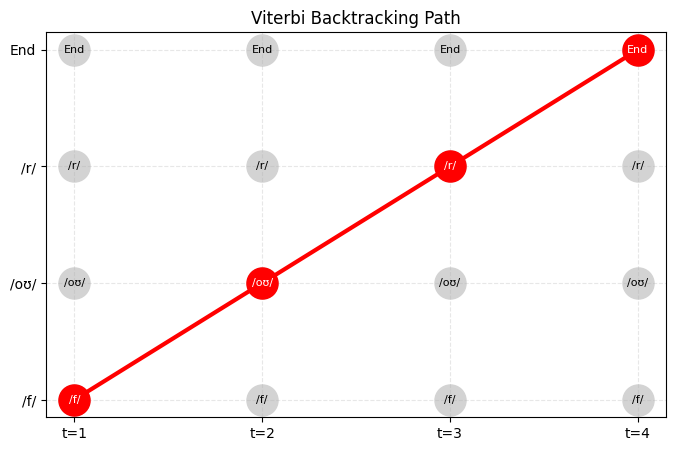

In [5]:
# Backtracking
T = 4
# 1. Find best final state
last_time_idx = T - 1
best_last_state = np.argmax(delta[:, last_time_idx])
best_path_indices = [best_last_state]

print(f"Best final state at t={T}: {states[best_last_state]} (Prob: {delta[best_last_state, last_time_idx]:.5f})")

# 2. Backtrack
# Loop from T-1 down to 1 (indices T-2 down to 0)
for t in range(last_time_idx, 0, -1):
    # Current state in path is best_path_indices[-1]
    # Look up who sent us there using psi at time t (which points to t-1)
    # Note: psi column t stores pointer FROM t-1
    prev_state = psi[best_path_indices[-1], t]
    best_path_indices.append(prev_state)

# Reverse to get chronological order
best_path_indices = best_path_indices[::-1]
best_path_names = [states[i] for i in best_path_indices]

print("Optimal State Sequence:", " -> ".join(best_path_names))

# Visual: Path Diagram
# We'll draw the grid and highlight the path
fig, ax = plt.subplots(figsize=(8, 5))
# Draw grid nodes
for t in range(4):
    for s in range(n_states):
        ax.scatter(t+1, s, color='lightgray', s=500, zorder=1)
        ax.text(t+1, s, states[s], ha='center', va='center', fontsize=8, zorder=2)

# Draw all possible transitions (faint)
for t in range(1, 4):
    for s_to in range(n_states):
        s_from = psi[s_to, t]
        # This is just the best path to each node, not all transitions, but sufficient for viz
        # ax.plot([t, t+1], [s_from, s_to], color='gray', alpha=0.2)

# Draw Best Path (Red)
for t in range(3):
    s_curr = best_path_indices[t]
    s_next = best_path_indices[t+1]
    ax.plot([t+1, t+2], [s_curr, s_next], color='red', linewidth=3, zorder=3)
    ax.scatter(t+1, s_curr, color='red', s=500, zorder=4)
    ax.text(t+1, s_curr, states[s_curr], ha='center', va='center', color='white', fontsize=8, zorder=5)

# Draw final node
ax.scatter(4, best_path_indices[-1], color='red', s=500, zorder=4)
ax.text(4, best_path_indices[-1], states[best_path_indices[-1]], ha='center', va='center', color='white', fontsize=8, zorder=5)

ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["t=1", "t=2", "t=3", "t=4"])
ax.set_yticks(range(n_states))
ax.set_yticklabels(states)
ax.set_title("Viterbi Backtracking Path")
ax.grid(True, linestyle='--', alpha=0.3)
save_show("viterbi_backtracking_path.png")


### Part (c) Answer
> **Answer**:
> $\psi_t(i)$ is the **backpointer** that stores the index of the previous state $j$ that maximized the transition to state $i$ at time $t$.
> The backtracking process reconstructs the optimal path by:

> This traces the single best path from the end back to the start.


## 5. Full Demonstration of Viterbi Decoding

We wrap the logic into a clean function and visualize the result.


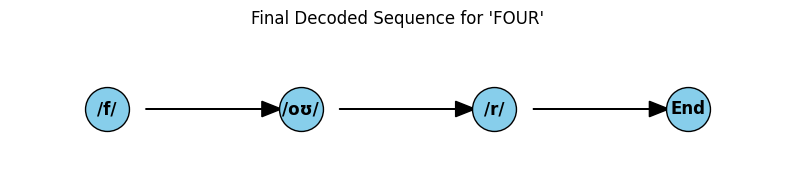

Decoded Path: ['/f/', '/oʊ/', '/r/', 'End']


In [6]:
def run_full_viterbi(A, B_obs, pi):
    n_states, T = B_obs.shape
    delta = np.zeros((n_states, T))
    psi = np.zeros((n_states, T), dtype=int)
    
    # Init
    delta[:, 0] = pi * B_obs[:, 0]
    
    # Recursion
    for t in range(1, T):
        for i in range(n_states):
            candidates = delta[:, t-1] * A[:, i]
            delta[i, t] = np.max(candidates) * B_obs[i, t]
            psi[i, t] = np.argmax(candidates)
            
    # Backtrack
    path = np.zeros(T, dtype=int)
    path[T-1] = np.argmax(delta[:, T-1])
    for t in range(T-2, -1, -1):
        path[t] = psi[path[t+1], t+1]
        
    return delta, psi, path

# Run
d, p, path_indices = run_full_viterbi(A, B_obs, pi)

# Visualize Result
plt.figure(figsize=(10, 2))
path_names = [states[i] for i in path_indices]
for i, name in enumerate(path_names):
    plt.scatter(i+1, 0, s=1000, c='skyblue', edgecolors='black')
    plt.text(i+1, 0, name, ha='center', va='center', fontsize=12, fontweight='bold')
    if i < len(path_names)-1:
        plt.arrow(i+1.2, 0, 0.6, 0, head_width=0.1, head_length=0.1, fc='k', ec='k')

plt.xlim(0.5, 4.5)
plt.ylim(-0.5, 0.5)
plt.axis('off')
plt.title("Final Decoded Sequence for 'FOUR'")
save_show("final_decoded_sequence.png")

print("Decoded Path:", path_names)


## 6. Final Summary

### (a) Initialization
The initialization $\delta_1(i) = \pi_i \cdot b_i(O_1)$ establishes the starting probabilities. For a left-to-right HMM like "FOUR", the constraint is strict: the sequence **must** start at the first phoneme (/f/). Thus, $\pi = [1, 0, 0, 0]$, resulting in $\delta_1(i) = 0$ for all states except the start state.

### (b) Viterbi vs Forward
The Viterbi algorithm uses the **max** operator to find the **single best path** (optimization problem).
The Forward algorithm uses the **sum** operator to find the **total probability** of the sequence (summation problem).
Viterbi asks "Which specific sequence of states is most likely?", while Forward asks "How likely is this observation sequence overall?".

### (c) Backtracking
Backtracking is the procedure to recover the optimal state sequence using the stored backpointers $\psi$.
Starting from the most probable final state at time $T$, we use $q_t = \psi_{t+1}(q_{t+1})$ to step backwards in time, retrieving the predecessor that led to the current optimal state. This reconstructs the path /f/ $	o$ /oʊ/ $	o$ /r/ $	o$ End.
